In [1]:
import sys
from pathlib import Path
from tqdm import tqdm
import pandas as pd
import numpy as np
import time
import base64
import zlib
from datasets import load_dataset
import random
from torchvision import transforms
from PIL import Image
import torch
import torch.nn.functional as F

sys.path.append(str(Path("..").resolve()))
from src import *

/leonardo_scratch/fast/IscrC_MACRO/Texture-Anything/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Generating validity masks for UVs

Currently, in the CNet training, the loss is computed as the MSE between the predicted and the ground truth texture like this:

```python
F.mse_loss(model_pred.float(), target.float(), reduction="mean")
```

This means that the loss considers all parts of the texture equally. However, parts that are not mapped in the UV should not affect training.

In this notebook we generate UV masks for the dataset in the `dataset/` folder.

In [2]:
DATASET_DIR = Path("dataset")
splits = list(DATASET_DIR.glob("*/"))
folders = (DATASET_DIR / splits[0]).glob("*/")

In [3]:
dataset = ObjaverseDataset3D()

## How are we going to export the masks?
Masks are exported as a numpy `ndarray` and packed using `packbits()` to achieve a $\approx 250 \times$ compression.

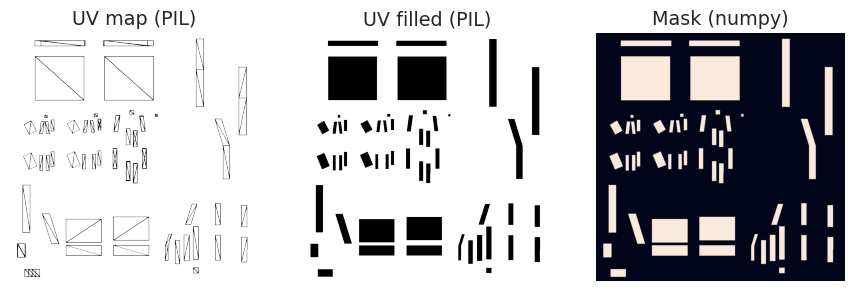

In [77]:
obj = dataset["4f2b29543a1e49ae9ff18c37e9069151"]
uv, uv_filled = obj.draw_uv_map(stroke=3), obj.draw_uv_map(fill=True)
mask = np.alltrue(np.array(uv_filled) == [0, 0, 0, 255], axis=2)
plot_images({"UV map (PIL)": uv, "UV filled (PIL)": uv_filled, "Mask (numpy)": mask})

In [ ]:
for split in splits:
    cprint("Processing", f"yellow:{split.name}:")
    mask_dir = split / "mask"
    mask_dir.mkdir(exist_ok=True)
    uids = [uv.stem for uv in (split / "uv").glob("*.png") if not (mask_dir / f"{uv.stem}.npy").exists()]

    for i, uid in enumerate(tqdm(uids)):
        obj = dataset[uid]
        uv_filled = obj.draw_uv_map(fill=True)
        mask = np.alltrue(np.array(uv_filled) == [0, 0, 0, 255], axis=2)
        np.save(mask_dir / f"{uid}.npy", np.packbits(mask))

## How can we store numpy maks in the dataset?
The dataset used by [`train_controlnet.py`](train_controlnet.py) is [`ImageDataset`](https://huggingface.co/docs/datasets/image_dataset#imagefolder). It does not support files other than images, like our `.npy` masks. At the best of my knowledge, we have 3 options:
1. **Store the masks as images** - the files would be much bigger and conversion to pytorch tensor will be more complex.
2. **Store as string, in the metadata.csv file** - this is the approach we choose.
3. **Change ImageDataset to another alternative** - this requires consistent edits in the [`train_controlnet.py`](train_controlnet.py). We refrain from messing with the diffuser's script if possible.

Let's see how we can serialize the masks as strings and how much memory does this require.

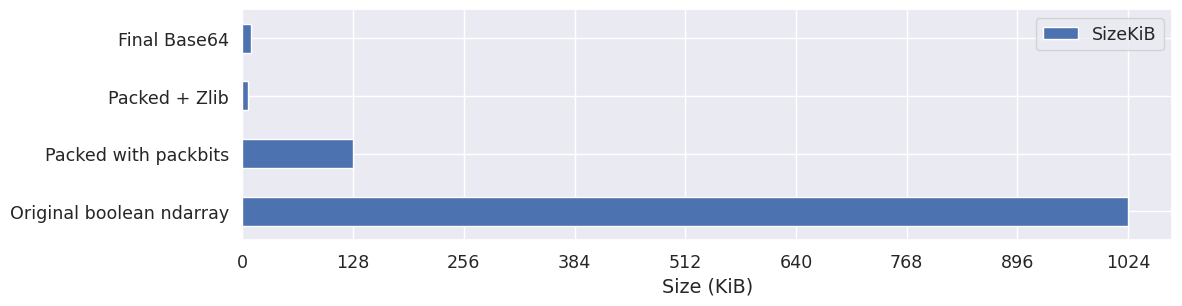

In [ ]:
sample = "dataset/validation/mask/0adf456c59094a3da23329a6d27cb239.npy"
packed = np.load(sample)
mask = np.unpackbits(packed).reshape(1024, 1024)
compressed = zlib.compress(packed.tobytes())
base64compressed = base64.b64encode(compressed).decode("utf-8")
sizes = pd.DataFrame(
    dict(SizeKiB=[x // 1024 for x in [mask.nbytes, packed.nbytes, len(compressed), len(base64compressed)]]),
    index=["Original boolean ndarray", "Packed with packbits", "Packed + Zlib", "Final Base64"],
)
ax = sizes.plot(y="SizeKiB", figsize=(12, 3), kind="barh")
ax.set_xlabel("Size (KiB)")
ax.set_xticks(range(0, 1025, 128))

The serialized string mask is <span style="color:red">10.82 KiB</span> in size.

In [33]:
def serialize_mask(npy_path) -> str:
    mask_packed = np.load(npy_path)
    mask_compressed = zlib.compress(mask_packed.tobytes())
    mask_base64 = base64.b64encode(mask_compressed)
    return mask_base64.decode("utf-8")


# Adjust metadata
for split in tqdm(splits):
    metadata = pd.read_csv(split / "metadata.csv")
    metadata["mask"] = metadata["uv_file_name"].apply(lambda x: serialize_mask(split / f"mask/{Path(x).stem}.npy"))
    metadata[["uv_file_name", "diffuse_file_name", "caption", "mask"]].to_csv(split / "metadata.csv", index=False)

## How to read the masks back?
Since they're packed, we need to call the `unpackbits` function and to `reshape` them back.

In [47]:
dataset = load_dataset(str(DATASET_DIR))
cprint(
    "Dataset has",
    f"green:{len(dataset['test'])} test samples,",
    f"yellow:{len(dataset['validation'])} validation samples,",
)

Resolving data files:   0%|          | 0/275 [00:00<?, ?it/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset has 137 test samples, 5 validation samples,


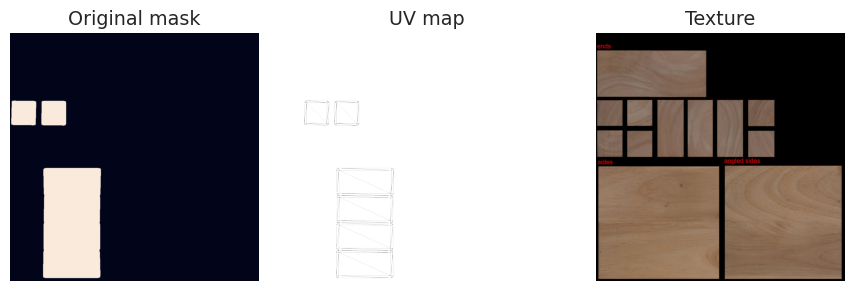

In [54]:
mask_str, uv, diffuse = (
    dataset["validation"]["mask"][0],
    dataset["validation"]["uv"][0],
    dataset["validation"]["diffuse"][0],
)
mask_compressed = base64.b64decode(mask_str)
mask_decompressed = zlib.decompress(mask_compressed)
mask_packed = np.frombuffer(mask_decompressed, dtype=np.uint8)
mask = np.unpackbits(mask_packed).reshape(1024, 1024)
plot_images(
    {
        "Original mask": mask,
        "UV map": uv,
        "Texture": diffuse,
    }
)

## How to compute the masked MSE loss?

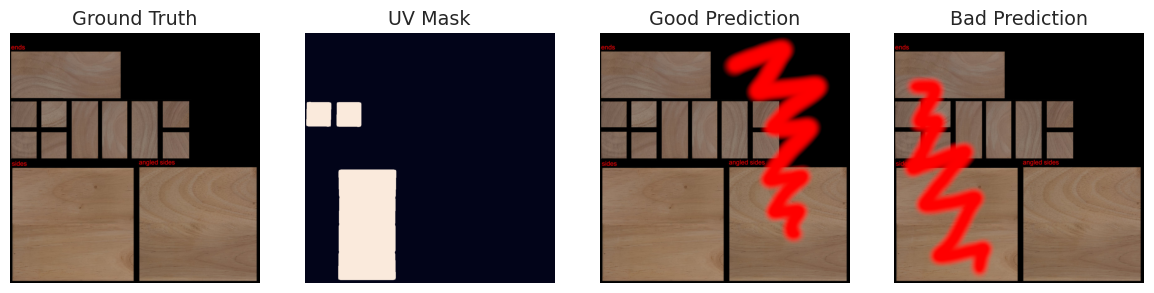

In [10]:
gt = Image.open("masked_loss_example/gt.png").convert("RGB")
mask = np.load("masked_loss_example/mask.npy")
pred_good = Image.open("masked_loss_example/pred_good.png").convert("RGB")
pred_bad = Image.open("masked_loss_example/pred_bad.png").convert("RGB")
plot_images({"Ground Truth": gt, "UV Mask": mask, "Good Prediction": pred_good, "Bad Prediction": pred_bad})

In [11]:
image_transforms = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5], [0.5])])
gt = image_transforms(gt).repeat(2, 1, 1, 1)  # Fake batch_size=2
mask = torch.from_numpy(mask).repeat(2, 1, 1)
pred_good = image_transforms(pred_good).repeat(2, 1, 1, 1)
pred_bad = image_transforms(pred_bad).repeat(2, 1, 1, 1)

In [12]:
cprint(
    "green:Original loss:\n",
    "Good Prediction =",
    round(F.mse_loss(pred_good.float(), gt.float(), reduction="mean").item(), 2),
    "\n",
    "Bad Prediction =",
    round(F.mse_loss(pred_bad.float(), gt.float(), reduction="mean").item(), 2),
)

Original loss:
 Good Prediction = 0.12 
 Bad Prediction = 0.07


In [ ]:
def masked_mse_loss(pred, targ, mask):
    """Compute the masked MSE loss

    Args:
        pred (torch.tensor): CNet output, shape=(N, C, W, H)
        targ (torch.tensor): Ground truth, shape=(N, C, W, H)
        mask (torch.tensor): UV mask, shape=(N, W, H)
    """
    _, channels, _, _ = pred.shape
    # Repeat the channels (the mask is B/W)
    mask = mask.float().unsqueeze(1).repeat(1, channels, 1, 1)
    # Resize the mask to args.resolution
    mask = F.interpolate(mask, size=pred.shape[2:], mode="nearest")
    loss_elems = (F.mse_loss(pred.float(), targ.float(), reduction="none")) * mask
    return loss_elems.sum() / (mask.sum() + 1e-6)

In [18]:
cprint(
    "green:Masked loss:\n",
    "Good Prediction =",
    round(masked_mse_loss(pred_good, gt, mask).item(), 2),
    "\n",
    "Bad Prediction =",
    round(masked_mse_loss(pred_bad, gt, mask).item(), 2),
)

Masked loss:
 Good Prediction = 0.0 
 Bad Prediction = 0.27


## Baked textures
Objaverse regenerated UV maps and baked textures do not seem to improve the quality of the dataset.

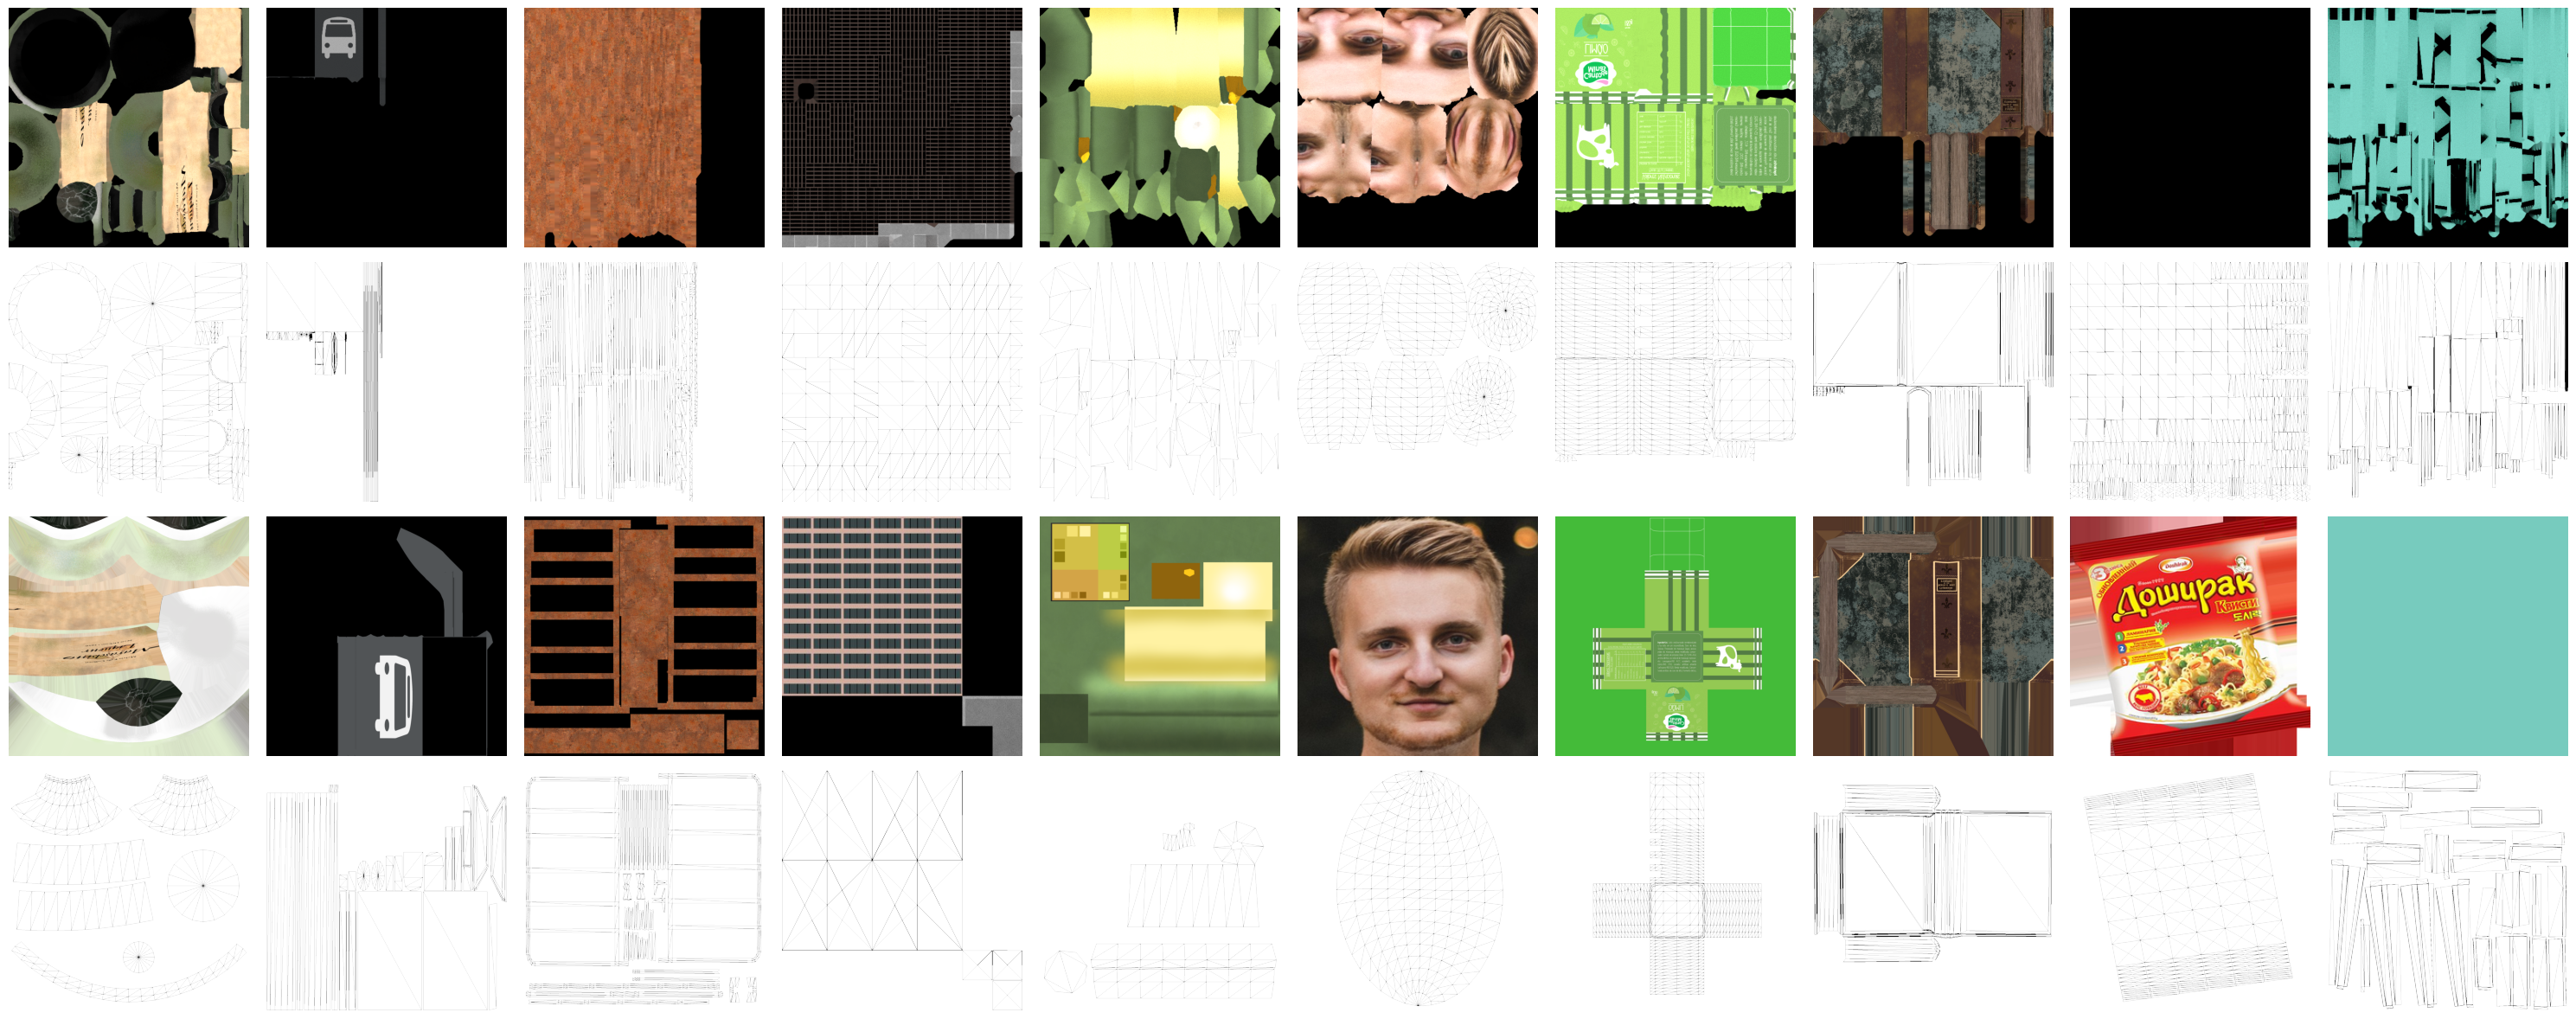

In [37]:
uids = [x.name for x in Path("../dataset/objaverse/diffuse/").glob("*.png")]
uids = list(random.choices(uids, k=10))
plot_images(
    [Path("../dataset/objaverse/diffuse/") / x for x in uids]
    + [Path("../dataset/objaverse/uv/") / x for x in uids]
    + [Path("../dataset/objaverse_bkp/diffuse/") / x for x in uids]
    + [Path("../dataset/objaverse_bkp/uv/") / x for x in uids]
)